<a href="https://colab.research.google.com/github/aquila00/MovieIt/blob/main/MovieIt_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação usando SVD



##Métodos de Recomendação usando Fatores Latentes

Um dos mais eficientes métodos de recomendação são os Métodos de Fatores Latentes, neles os valores estão "escondidos", ou seja, não são diretamente observáveis.

O princípio deste método é baseado em álgebra linear, mais especificamente na Transformada de Fourrier, que realiza a redução de dimensionalidade, criando um novo espaço de recursos, com poucas perdas, possibilitando cálculos mais rápidos em tempo real.

-Princípio resumido da Transformada de Fourrier 

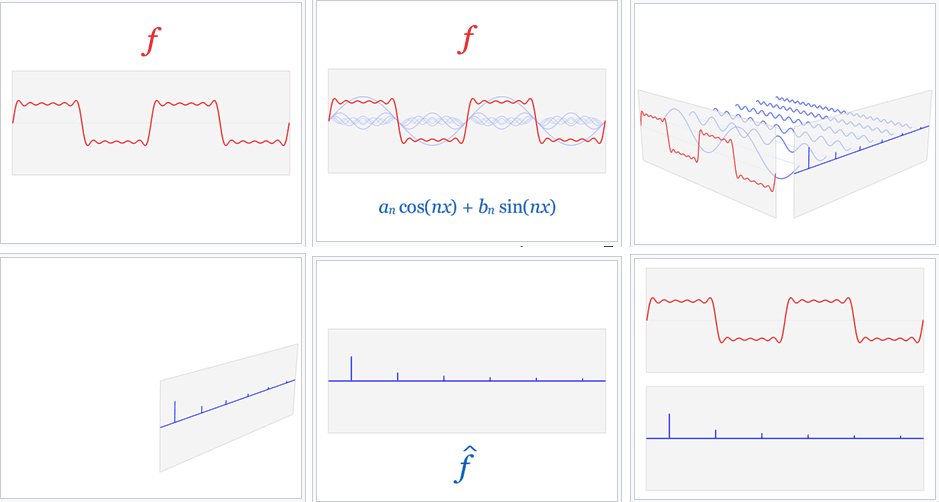


##SVD - Singular Value Decomposition


O SVD é um método de de fatoração matricial em que uma matriz **A** pode ser decomposta em três matrizes, de acordo com o Teorema:



$A = U\Sigma V^T$

onde:

$A =$ é a matriz de dados

$\Sigma =$ é matriz diagonal
- se e somente se

$S  V =$ são matrizes unitárias ou ortogonais
- se e somente se

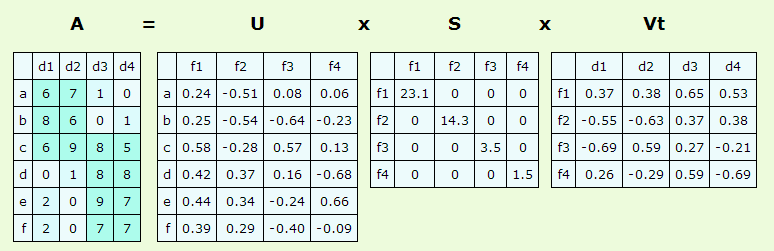

# biblioteca Scikit-Surprise

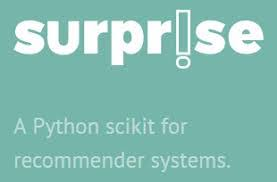


#Importando Bibliotecas

In [ ]:
!pip install scikit-surprise -q

# importando bibliotecas gerais
import numpy as np
import pandas as pd
from typing import * #(rodar o dict)

# importando bibliotecas para o cálculo de destância entre os usuários
import operator
from scipy.spatial.distance import cosine

# bibliotecas KNN
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

# biblioteca para o RMSE
from sklearn.metrics import mean_squared_error

# biblioteca SVD surprise (netflix)
from surprise import Dataset, SVD, Reader, accuracy, AlgoBase
from surprise.model_selection import cross_validate, train_test_split

# google drive / colab
from google.colab import drive

     |████████████████████████████████| 11.8 MB 6.1 MB/s 


In [ ]:
# Acessando os arquivos no GoogleDrive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importando Base de dados

In [ ]:
path = '/content/gdrive/MyDrive/movieit/ml-1m'

# importação dos arquivos de dados e atribuição de nomes às colunas

#avaliações dos filmes
db_rating = pd.read_csv(f'{path}/ratings.dat', names=['userid', 'movieid', 'rating', 'timestamp'], usecols=['userid', 'movieid', 'rating'], skiprows=1, header=None, sep='::')

#listagem dos filmes quanto aos seus gêneros
db_movie = pd.read_csv(f'{path}/movies.dat', names=['movieid', 'movietitle', 'genres'], skiprows=1, header=None, sep='::')

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


#Tradução dos gênero

In [ ]:
# excluindo a lista de Gêneros em inglês
db_movie.drop(columns='genres', inplace=True)

In [ ]:
db_movie

,movieid,movietitle
0,2,Jumanji (1995)
1,3,Grumpier Old Men (1995)
2,4,Waiting to Exhale (1995)
3,5,Father of the Bride Part II (1995)
4,6,Heat (1995)
...,...,...
3877,3948,Meet the Parents (2000)
3878,3949,Requiem for a Dream (2000)
3879,3950,Tigerland (2000)
3880,3951,Two Family House (2000)


#Exploratória

In [ ]:
n_ratings = len(db_rating)
n_users = len(db_rating['userid'].unique())
n_movies_avaliados = len(db_rating['movieid'].unique())
print(f'Total de ratings: {n_ratings}')
print(f'Total de usuários únicos: {n_users}')
print(f'Total de filmes: {n_movies_avaliados}')
print(f'Média de ratings/user: {round(n_ratings/n_users, 2)}')
esparsidade = round(1.0 -n_ratings/float(n_users * n_movies_avaliados),3)
print(f'Esparsidade da base é de: {(esparsidade*100)}%')

Total de ratings: 1000208
Total de usuários únicos: 6040
Total de filmes: 3706
Média de ratings/user: 165.6
Esparsidade da base é de: 95.5%


#Desenvolvendo o SVD

##Passo 1: preparando o dataset

=> user x ratings

In [ ]:
# original
db_rating

,userid,movieid,rating
0,1,661,3
1,1,914,3
2,1,3408,4
3,1,2355,5
4,1,1197,3
...,...,...,...
1000203,6040,1091,1
1000204,6040,1094,5
1000205,6040,562,5
1000206,6040,1096,4


In [ ]:
# adicionando  atributo gêneros
db_movie

,movieid,movietitle
0,2,Jumanji (1995)
1,3,Grumpier Old Men (1995)
2,4,Waiting to Exhale (1995)
3,5,Father of the Bride Part II (1995)
4,6,Heat (1995)
...,...,...
3877,3948,Meet the Parents (2000)
3878,3949,Requiem for a Dream (2000)
3879,3950,Tigerland (2000)
3880,3951,Two Family House (2000)


In [ ]:
# adicionando  atributo movietitle
db_rating = db_rating.merge(db_movie, left_on='movieid', right_on='movieid', how='left')

In [ ]:
# db_rating[db_rating.userid ==742]
db_rating

,userid,movieid,rating,movietitle
0,1,661,3,James and the Giant Peach (1996)
1,1,914,3,My Fair Lady (1964)
2,1,3408,4,Erin Brockovich (2000)
3,1,2355,5,"Bug's Life, A (1998)"
4,1,1197,3,"Princess Bride, The (1987)"
...,...,...,...,...
1000203,6040,1091,1,Weekend at Bernie's (1989)
1000204,6040,1094,5,"Crying Game, The (1992)"
1000205,6040,562,5,Welcome to the Dollhouse (1995)
1000206,6040,1096,4,Sophie's Choice (1982)


##Passo2: criando o Reader

==> a função Reader seja para indicar os limites inferiores e superiores de ratings na biblioteca SVD Surprise

==> min = 1 | max = 5

este valor é arbitrário

In [ ]:
reader = Reader(rating_scale=(1, 5))

##Passo 3: criando uma nova instância com o dataset e o reader

- O dataset precisa de 3 colunas na ordem específica: (user_id, product_id, rating) 

In [ ]:
db_rating_svd = db_rating
# excluindo colunas não demandadas pela biblioteca
db_rating_svd = db_rating_svd[['userid','movietitle','rating']]

In [ ]:
db_rating_svd

,userid,movietitle,rating
0,1,James and the Giant Peach (1996),3
1,1,My Fair Lady (1964),3
2,1,Erin Brockovich (2000),4
3,1,"Bug's Life, A (1998)",5
4,1,"Princess Bride, The (1987)",3
...,...,...,...
1000203,6040,Weekend at Bernie's (1989),1
1000204,6040,"Crying Game, The (1992)",5
1000205,6040,Welcome to the Dollhouse (1995),5
1000206,6040,Sophie's Choice (1982),4


In [ ]:
# cria um novo Dataset com um DataFrame e o reader
data = Dataset.load_from_df(db_rating_svd, reader)

#Passo 4 - Treinando o modelo com o dataset data



In [ ]:
# definindo a base de treino e de teste com 0,25% para o teste
trainset, testset = train_test_split(data, test_size=.25)

In [ ]:
# treinando um novo SVD com x atributos latentes (numéro definido arbitrariamente)
model = SVD(n_factors=50)
model.fit(trainset)

In [ ]:
model.qi

array([[ 0.00762625,  0.01301382, -0.04572011, ...,  0.1201913 ,
        -0.02882338, -0.19641348],
       [ 0.05363017, -0.06265478,  0.2093146 , ...,  0.1991408 ,
        -0.16098811,  0.08866484],
       [-0.01411865, -0.0179916 , -0.24545422, ...,  0.24790822,
         0.1781979 , -0.08257472],
       ...,
       [-0.00628877,  0.03245235, -0.19494966, ..., -0.0110167 ,
        -0.08675718, -0.09690874],
       [ 0.18114242, -0.16733065, -0.06271502, ...,  0.05513838,
        -0.03447234, -0.04127667],
       [ 0.09175078,  0.01257524, -0.08240108, ..., -0.09373423,
        -0.10105894, -0.16390463]])

In [ ]:
model.qi.shape

(3677, 50)

##Normalização

In [ ]:
# Normalização utilizando álgebra linear
pd.DataFrame(model.qi).iloc[0].pow(2).sum()
model.qi /= np.linalg.norm(model.qi, ord=2, axis=1).reshape(-1, 1)
pd.DataFrame(model.qi).iloc[0].pow(2).sum()

1.0

In [ ]:
model.qi

array([[ 0.0108551 ,  0.01852368, -0.06507733, ...,  0.17107853,
        -0.04102678, -0.27957204],
       [ 0.02791755, -0.03261537,  0.10896013, ...,  0.10366409,
        -0.08380344,  0.04615508],
       [-0.01374672, -0.01751765, -0.23898826, ...,  0.24137761,
         0.17350366, -0.08039947],
       ...,
       [-0.00873464,  0.04507391, -0.27077064, ..., -0.01530138,
        -0.1204993 , -0.13459907],
       [ 0.26062041, -0.2407486 , -0.09023185, ...,  0.07933089,
        -0.04959742, -0.05938721],
       [ 0.11942036,  0.01636759, -0.10725104, ..., -0.12200197,
        -0.13153561, -0.21333389]])

##Inspecionando o Modelo - Mapeando a estrutura de cada vetor gerado pelo algortimo

In [ ]:
# qi = matriz de filmes com seus atributos latentes ou seja:
# o dataset possui 1662 filmes únicos com os x recursos latentes conforme definido no modelo (n_factors = 100)
model.qi.shape

(3677, 50)

In [ ]:
# função para converter o item_to_row_idx em um dataframe e visualizar com heads
#permitindo a visualização
def display(df: pd.DataFrame):
    item_to_row_idx_df = pd.DataFrame(
        list(item_to_row_idx.items()),
        columns=['Movie name', 'model.qi row idx'],
    ).set_index('Movie name')
    return item_to_row_idx_df.head(5)

In [ ]:
item_to_row_idx: Dict[Any, int] = model.trainset._raw2inner_id_items

# display() definida acima é uma função para melhor visualizar 'item_to_row_idx'
display(item_to_row_idx)

,model.qi row idx
Movie name,
"Great Ziegfeld, The (1936)",0
Clerks (1994),1
Some Folks Call It a Sling Blade (1993),2
William Shakespeare's Romeo and Juliet (1996),3
"Truman Show, The (1998)",4


In [ ]:
# encontrando index na lista de filmes (o nome do filme é index do df)
filme = 'Nell (1994)'
filme_idx: int = item_to_row_idx[filme]
print(filme_idx)

381


In [ ]:
# visualizando a matriz gerada pelo modelo a partir dos x atributos latentes para o filme especificado
model.qi[filme_idx]

array([ 0.05066851,  0.03830993, -0.16653532, -0.19639908,  0.05157021,
       -0.00518792, -0.003142  , -0.24705322,  0.06428413,  0.04098276,
       -0.11446188, -0.09041672,  0.05339138,  0.0964709 , -0.07570809,
       -0.06889914,  0.01053926, -0.01867499,  0.0310049 ,  0.32182028,
       -0.09311783,  0.08696392,  0.00639612, -0.00373018,  0.068278  ,
        0.14684249,  0.02578747,  0.03281769,  0.09858084, -0.02162214,
        0.08705075,  0.32387494,  0.24455861, -0.07472828,  0.04057743,
       -0.00617091,  0.20121448,  0.214106  , -0.0909875 ,  0.03785792,
       -0.02350155, -0.09212236, -0.14325626,  0.34590531, -0.11671874,
        0.41932963,  0.08382909,  0.15639103, -0.07609185,  0.07233861])

In [ ]:
# conferindo os x atributos latentes gerados para o filme escolhido
print(f"Cada Produto tem: {model.qi[filme_idx].shape[0]} atributos")

Cada Produto tem: 50 atributos


#Recomendações via filtragem colaborativa baseada em produto: encontrando similaridade entre vetores

In [ ]:
# dataset de usuários
db_rating_svd.head()

,userid,movietitle,rating
0,1,James and the Giant Peach (1996),3
1,1,My Fair Lady (1964),3
2,1,Erin Brockovich (2000),4
3,1,"Bug's Life, A (1998)",5
4,1,"Princess Bride, The (1987)",3


In [ ]:
def get_vector_by_movie_title(movie_title: str, trained_model: SVD) -> np.array:
    """Retorna os atributos latentes dos filmes, em formato numpy array"""
    movie_row_idx = trained_model.trainset._raw2inner_id_items[movie_title]
    return trained_model.qi[movie_row_idx]


def cosine_distance(vector_a: np.array, vector_b: np.array) -> float:
    """retorna um número (float) de similaridades, cosseno, entre dois vetores"""
    return cosine(vector_a, vector_b)

In [ ]:
# Fetch the vectors of "Toy Story" and "Wizard of Oz"
filme1_id = 'James and the Giant Peach (1996)'
filme2_id =  'My Fair Lady (1964)'

filme1_vec = get_vector_by_movie_title(filme1_id, model)
filme2_vec = get_vector_by_movie_title(filme2_id, model)

# Calculate the distance between the vectors. The smaller the number,
# the more similar the two movies are
similarity_score = cosine_distance(filme1_vec, filme2_vec)
similarity_score

0.9679712384470928

#Recommendações via Matriz de *Reconstrução*

## Recomendações via reconstrução de matriz: usando a API predict() dentro do Surprise

- Prever uma pontuação entre qualquer combinação de usuário e um filme

In [ ]:
# dataset de usuários
db_rating_svd.head()

,userid,movietitle,rating
0,1,James and the Giant Peach (1996),3
1,1,My Fair Lady (1964),3
2,1,Erin Brockovich (2000),4
3,1,"Bug's Life, A (1998)",5
4,1,"Princess Bride, The (1987)",3


In [ ]:
# utilizando o API de previsão: é necessário dois parâmetros, useid e filme
user_id = 15
movie_id = 'James and the Giant Peach (1996)'
model.predict(user_id, movie_id)

Prediction(uid=15, iid='James and the Giant Peach (1996)', r_ui=None, est=2.616440208286419, details={'was_impossible': False})

## Recomendações por Similaridade de Itens


- clusterização: encontrar um grupo de itens similares
- item-based: encontrar um item baseado em filtragem colaborativa  

### Recomendações por Similaridade de Itens: Encontrando similaridade entre vetores

- a similaridade aqui é obtida através da medida de cosseno. Quanto mais a aproximação com o valor 0 (zero), mais similares são considerados os itens

In [ ]:
# listagem dos filmes a serem comparados
filme1_id = 'James and the Giant Peach (1996)'
filme2_id = 'My Fair Lady (1964)'
filme3_id = 'Erin Brockovich (2000)'
filme4_id = 'Princess Bride, The (1987)'

# obtendo o índice dos filmes selecionados
filme1_idx = model.trainset._raw2inner_id_items[filme1_id]
filme2_idx = model.trainset._raw2inner_id_items[filme2_id]
filme3_idx = model.trainset._raw2inner_id_items[filme3_id]
filme4_idx = model.trainset._raw2inner_id_items[filme4_id]

In [ ]:
# criando os vetores para os filmes
filme1_vector = model.qi[filme1_idx]
filme2_vector = model.qi[filme2_idx]
filme3_vector = model.qi[filme3_idx]
filme4_vector = model.qi[filme4_idx]
dist1 = cosine_distance(filme1_vector, filme2_vector)
dist2 = cosine_distance(filme1_vector, filme3_vector)
dist3 = cosine_distance(filme1_vector, filme4_vector)

In [ ]:
# calculando a distância de cosseno entre os filmes
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme2_id} é: {dist1}.")
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme3_id} é: {dist2}.")
print(f"A distância de cosseno entre o filme {filme1_id} e o filme {filme4_id} é: {dist3}.")

A distância de cosseno entre o filme James and the Giant Peach (1996) e o filme My Fair Lady (1964) é: 0.9679712384470928.
A distância de cosseno entre o filme James and the Giant Peach (1996) e o filme Erin Brockovich (2000) é: 1.1427835616692406.
A distância de cosseno entre o filme James and the Giant Peach (1996) e o filme Princess Bride, The (1987) é: 0.9180463943239541.


###Encontrar filmes semelhantes por ranking

- este procedimento implica na criação de uma função que recebe como argumento o título de um filme e apresenta a semelhança entre este filme, através de seu rankin, com todos os outros filmes da abase de dados.

In [ ]:
def display(similarity_table):
    """Visualizar a lista de filmes indicados por similaridade"""
    similarity_table = pd.DataFrame(
        similarity_table,
        columns=['vector cosine distance', 'movie title']
    ).sort_values('vector cosine distance', ascending=True)
    return similarity_table.iloc[:15]

In [ ]:
def get_top_similarities(movie_title: str, model: SVD) -> pd.DataFrame:
    """Returns the top 5 most similar movies to a specified movie"""
    ...

In [ ]:
def get_top_similarities(movie_title: str, model: SVD) -> pd.DataFrame:
    """Returns the top 5 most similar movies to a specified movie
    
    This function iterates over every possible movie in MovieLens and calculates
    distance between `movie_title` vector and that movie's vector.
    """
    
    # Get the first movie vector
    movie_vector: np.array = get_vector_by_movie_title(movie_title, model)
    similarity_table = []
    
    # Iterate over every possible movie and calculate similarity
    for other_movie_title in model.trainset._raw2inner_id_items.keys():
        other_movie_vector = get_vector_by_movie_title(other_movie_title, model)
        
        # Get the second movie vector, and calculate distance
        similarity_score = cosine_distance(other_movie_vector, movie_vector)
        similarity_table.append((similarity_score, other_movie_title))
    
    # sort movies by ascending similarity
    return display(sorted(similarity_table))

In [ ]:
filme_id = 'James and the Giant Peach (1996)'
get_top_similarities(filme_id, model)

,vector cosine distance,movie title
0,0.000000,James and the Giant Peach (1996)
1,0.457914,"Nightmare Before Christmas, The (1993)"
2,0.464291,Ed Wood (1994)
3,0.465078,Edward Scissorhands (1990)
4,0.475610,Chicken Run (2000)
5,0.491313,"Cook the Thief His Wife & Her Lover, The (1989)"
6,0.493501,Gentleman's Agreement (1947)
7,0.518313,Joe Gould's Secret (2000)
8,0.524295,Three Kings (1999)
9,0.527224,"Sweet Hereafter, The (1997)"


##Resultado Item Based

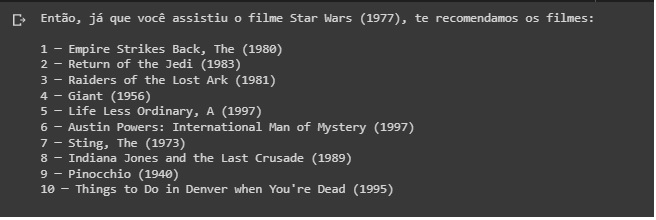

In [ ]:
filme_id = "Bug's Life, A (1998)"
get_top_similarities(filme_id, model)

,vector cosine distance,movie title
0,0.000000,"Bug's Life, A (1998)"
1,0.260024,NaN
2,0.266609,Toy Story 2 (1999)
3,0.371069,Aladdin (1992)
4,0.456172,Lady and the Tramp (1955)
5,0.463053,Beauty and the Beast (1991)
6,0.464134,Babe (1995)
7,0.484982,"Little Mermaid, The (1989)"
8,0.492672,Sense and Sensibility (1995)
9,0.498055,"Rescuers Down Under, The (1990)"


#Métricas

In [ ]:
#mostra a escala de erro
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8741  0.8728  0.8736  0.8727  0.8740  0.8734  0.0006  
MAE (testset)     0.6859  0.6849  0.6853  0.6846  0.6862  0.6854  0.0006  
Fit time          50.43   51.27   49.85   50.13   49.21   50.18   0.68    
Test time         2.14    2.96    2.70    2.77    4.54    3.02    0.81    


{'test_rmse': array([0.87405787, 0.87281811, 0.87358712, 0.87267418, 0.87401698]),
 'test_mae': array([0.68593553, 0.68487656, 0.68531608, 0.68463704, 0.68620566]),
 'fit_time': (50.42807579040527,
  51.27095293998718,
  49.853391885757446,
  50.13332390785217,
  49.214115381240845),
 'test_time': (2.1397955417633057,
  2.9638187885284424,
  2.701190948486328,
  2.770739793777466,
  4.538458824157715)}

#Conclusão:

- SVD é uma técnica realmente poderosa para fornecer recomendações;

- Os recursos latentes podem ser usados ​​de várias maneiras diferentes;

- Depois que os recursos latentes são gerados, a filtragem colaborativa torna-se totalmente independente de plataforma. Os vetores são muito portáteis.